<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/17-representation-learning-and-generative-learning-using-autoencoders-and-gans/4_understanding_lstm_and_gru_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding the LSTM and GRU layers

**A major characteristic of all neural networks you’ve seen so far, such as densely connected networks and convnets, is that they have no memory. Each input shown to them is processed independently, with no state kept in between inputs.**

**With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point.**

For instance, this is what you did in the IMDB example: an entire movie review was transformed into a single large vector(flatten) and processed in one go. Such networks are called **feedforward networks**.

In contrast, as you’re reading the present sentence, you’re processing it word by word—or rather, eye saccade by eye saccade—while keeping memories of what came before; this gives you a fluid representation of the meaning conveyed by this sentence.

**Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in**.

A **recurrent neural network (RNN)** adopts the same principle, albeit in an extremely simplified version: **it processes sequences by iterating through the sequence elements and maintaining a state containing information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop.**

The state of the RNN is reset between processing two different,
independent sequences (such as two different IMDB reviews), so you still consider one sequence a single data point: **a single input to the network. What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequence elements.**

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/recurrent-neural-network.png?raw=1' width='800'/>

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, SimpleRNN, Embedding

from tensorflow.keras.datasets import imdb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd

import string
import os

import matplotlib.pyplot as plt
%matplotlib inline

## Understanding the LSTM and GRU layers

The process you just naively implemented in Numpy corresponds to an actual Keras layer—the SimpleRNN layer:

```python
from keras.layers import SimpleRNN
```

There is one minor difference: **SimpleRNN processes batches of sequences, like all other Keras layers, not a single sequence as in the Numpy example**. This means it takes inputs of shape (batch_size, timesteps, input_features), rather than (timesteps, input_features).

**Like all recurrent layers in Keras, SimpleRNN can be run in two different modes**: it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape (batch_size, timesteps, output_features)) or only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). **These two modes are controlled by the return_sequences constructor argument**. 

Let’s look at an example that uses SimpleRNN and returns only the output at the last timestep:


In [0]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


The following example returns the full state sequence:

In [0]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It’s sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all of the intermediate layers to return full sequence of outputs:

In [0]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # Last layer only returns the last output
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now, let’s use such a model on the IMDB movie-review-classification problem. First, preprocess the data.

In [0]:
maxlen = 500            # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data()
print(len(input_train), ' train sequences')
print(len(input_test), ' test sequences')

print('Pad sequences (samples x time)')
input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000  train sequences
25000  test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an Embedding layer and a SimpleRNN layer:

In [0]:
# number of words to consider as features
voc_size = (input_train.max()+1).astype('int64')
print(voc_size)

model = Sequential()
model.add(Embedding(voc_size, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

88587
Epoch 1/10
157/157 [==============================] - 54s 341ms/step - loss: 0.6106 - accuracy: 0.6487 - val_loss: 0.4208 - val_accuracy: 0.8142
Epoch 2/10
157/157 [==============================] - 54s 341ms/step - loss: 0.3563 - accuracy: 0.8530 - val_loss: 0.4073 - val_accuracy: 0.8156
Epoch 3/10
157/157 [==============================] - 54s 341ms/step - loss: 0.2453 - accuracy: 0.9094 - val_loss: 0.3503 - val_accuracy: 0.8550
Epoch 4/10
157/157 [==============================] - 54s 342ms/step - loss: 0.1599 - accuracy: 0.9441 - val_loss: 0.3644 - val_accuracy: 0.8552
Epoch 5/10
157/157 [==============================] - 54s 345ms/step - loss: 0.1039 - accuracy: 0.9647 - val_loss: 0.5653 - val_accuracy: 0.7654
Epoch 6/10
157/157 [==============================] - 53s 340ms/step - loss: 0.0647 - accuracy: 0.9790 - val_loss: 0.6242 - val_accuracy: 0.7638
Epoch 7/10
157/157 [==============================] - 53s 340ms/step - loss: 0.0427 - accuracy: 0.9872 - val_loss: 0.4754 - 

Let's display the training and validation loss and accuracy:

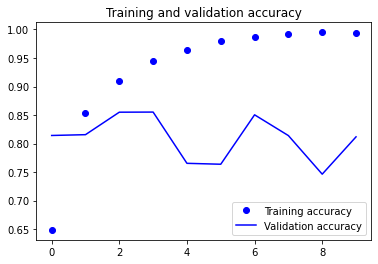

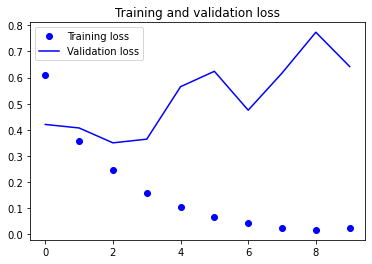

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). 

Part of the problem is that our inputs only consider the first 500 words rather the full sequences -- hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that SimpleRNN isn't very good at processing long sequences, like text. 

Other types of recurrent layers perform much better. Let's take a look at some more advanced layers.